In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import pingouin as pg
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import matplotlib.pyplot as plt

%matplotlib inline

import datetime

sns.set(rc={'figure.figsize' : (12, 6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Загрузим данные, посмотрим на кол-во строк в датасэте, проверим на наличие пропусков

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bagirjan/Statistics/LESSON_4/experiment_lesson_4.csv')

In [3]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [12]:
df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [6]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [9]:
df.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

In [7]:
df.shape

(20196, 4)

In [8]:
df.describe()

,order_id,delivery_time
count,20196.000000,20196.000000
mean,11103.503565,42.054169
std,5835.424404,10.382196
min,1000.000000,10.000000
25%,6048.750000,35.000000
50%,11109.500000,42.000000
75%,16158.250000,49.000000
max,21207.000000,83.000000


district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

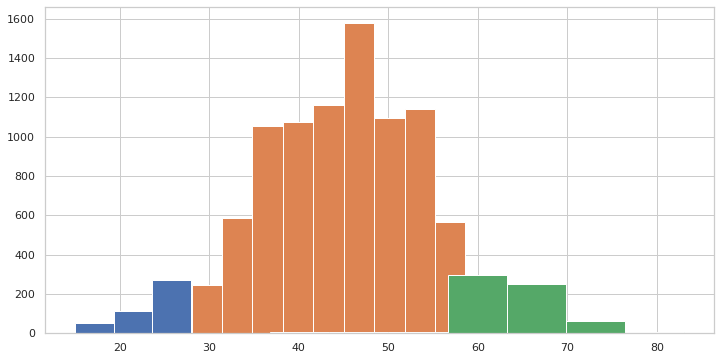

In [11]:
df.query('experiment_group == "control"')\
    .groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

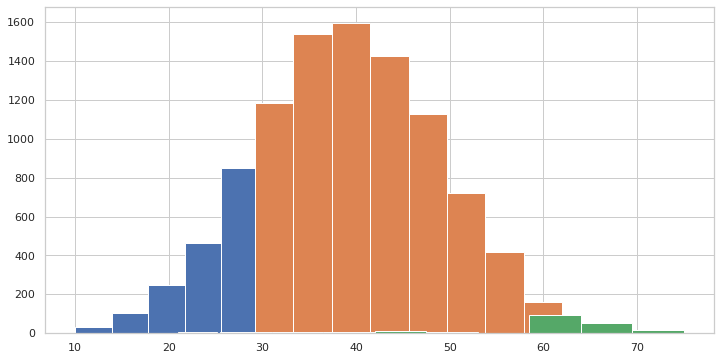

In [13]:
df.query('experiment_group =="test"')\
    .groupby('district').delivery_time.hist()

In [16]:
df.query('experiment_group == "test"').shape[0] - df.query('experiment_group == "control"').shape[0]

12

Сформулируем гипотезы для проверки:

Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [21]:
#Фильтруемся по группам
control = df.query('experiment_group == "control"').delivery_time
test = df.query('experiment_group == "test"').delivery_time

In [23]:
#Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона
ss.normaltest(control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [24]:
ss.normaltest(test)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [26]:
#Еще проверим через библиотеку pingouin
pg.normality(data=df, dv='delivery_time', 
                  group='experiment_group', method='normaltest')

,W,pval,normal
control,0.253498,0.880955,True
test,7.024157,0.029835,False


In [29]:
np.round(np.std(control), 2)

9.99

In [30]:
np.round(np.std(test), 2)

9.88

Cравним средние в тесте и контроле

In [35]:
df.groupby('experiment_group', as_index=False)\
    .agg({'delivery_time' : 'mean'})

,experiment_group,delivery_time
0,control,45.065101
1,test,39.046813


Подготовка данных

In [36]:
control_mean = df.query('experiment_group == "control"').delivery_time.mean()

In [38]:
test_mean = df.query('experiment_group == "test"').delivery_time.mean()

In [44]:
#Для сравнения средних используем t-критерий Стьюдента
ttest_ind(test, control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [47]:
#Дополнительно проверим через библиотеку пингвин
pg.ttest(x=df.query('experiment_group == "test"').delivery_time,
         y=df.query('experiment_group == "control"').delivery_time)

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


In [48]:
#Попробуем для сравнения Манна-Уитни

mannwhitneyu(x=df.query('experiment_group == "test"').delivery_time,
        y=df.query('experiment_group == "control"').delivery_time)

MannwhitneyuResult(statistic=33985060.0, pvalue=0.0)

На основе данного теста делаем вывод, что группы тест и контроль между собой различаются

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной? 

In [49]:
# Среднее теста составляет 86% от контроля
test_mean / control_mean

0.8664534687833919

In [50]:
#если мы вычитаем из единицы, мы получаем в процентах на сколько % среднее по тесту отличается от контроля
1 - test_mean / control_mean

0.1335465312166081

In [53]:
np.round((1 - (test_mean) / control_mean)*100, 2)

13.35

В тестовой группе среднее время доставки уменьшилось на 13.35%

Что в итоге? Катим?
Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.
